# CIFAR10 image classification in PyTorch

# Setup

In [2]:
!pip install ray
!pip install hpbandster ConfigSpace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.4 MB 1.3 MB/s 
     |████████████████████████████████| 4.1 MB 38.1 MB/s 
     |████████████████████████████████| 8.8 MB 46.0 MB/s 
     |████████████████████████████████| 468 kB 48.5 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.48.1
    Uninstalling grpcio-1.48.1:
      Successfully uninstalled grpcio-1.48.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 117 kB/s 
     |████████████████████████████████| 4.9 MB 8.5 MB/s 
     |████████████████████████████████| 89 kB 8.6 MB/s 
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=80006 sha256=d9e73107e269ed1128870385baba1b605ad8618dd3f3795cef50157d73fec95e
  Stored in directory: /root/.cache/pip/wheels/d9/88/fc/61ab6b9f386a386839668631c39a6dc3

In [3]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torchvision

from matplotlib import pyplot as plt
from random import randrange
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import HyperBandForBOHB, ASHAScheduler
from ray.tune.suggest.bohb import TuneBOHB
from ray.tune.suggest.hyperopt import HyperOptSearch
from tabulate import tabulate
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The module `ray.tune.suggest.bohb` has been moved to `ray.tune.search.bohb` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest.bohb` with `ray.tune.search.bohb`.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The module `ray.tune.suggest.hyperopt` has been moved to `ray.tune.search.hyperopt` and the old location will be deprecated soon. Please adjust your imports to point to the new location

In [4]:
# Setting Seaborn general theme
sns.set_theme(palette='pastel')

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
class color:
    cyan = '\033[36m'
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'

# Data collection

*The* **CIFAR10** dataset is available in the `Torchvision.datasets` module.

In [7]:
# standard cast into Tensor and pixel values normalization in [-1, 1] range
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
validationset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


The `transform` parameter, for the train, validation and test set:

1. Converts the `numpy.ndarray` to a `torch.Tensor`. Tensors can be used on a GPU to accelerate computing.
2. Normalize pixel values, from [0, 255] to [-1, 1]. This is the optimal range to let the CNN perform at her best.

Then it apply the `RandomCrop` and `RandomHorizontalFlip` for the trainset only, in order to achieve better performance, in particular:

1. `RandomHorizontalFlip` will simply randomly flip the image horizontally with a probability of 0.5.
2. `RandomCrop` will crop the image for the specified size (32x32), after adding a padding of 4 pixels on each side. The `padding_mode='reflect'` will, from torch documentation:  
> Pads with reflection of image without repeating the last value on the edge.

We eventually define a useful dict that return text label given the index of the same.

In [8]:
IDX_TO_LABEL = {v: k for k, v in trainset.class_to_idx.items()}

# Data analysis

The **CIFAR10** dataset is composed of 60000 32x32 colour images (RGB), divided in 10 classes. 50000 images for the training set and 10000 for the test set.

## Samples and classes

In [9]:
print(f'{color.bold}{color.cyan}Training set{color.end}')
print(f'Samples: {trainset.data.shape}')
print(f'Labels: {len(trainset.targets)}')

Training set
Samples: (50000, 32, 32, 3)
Labels: 50000


In [10]:
print(f'{color.bold}{color.cyan}Test set{color.end}')
print(f'Samples: {testset.data.shape}')
print(f'Labels: {len(testset.targets)}')

Test set
Samples: (10000, 32, 32, 3)
Labels: 10000


In [11]:
print(f'{color.bold}{color.cyan}Classes{color.end}\n')
print(tabulate(
    list(trainset.class_to_idx.items()), headers=['Name', 'Index'], 
    tablefmt='orgtbl'
))

Classes

| Name       |   Index |
|------------+---------|
| airplane   |       0 |
| automobile |       1 |
| bird       |       2 |
| cat        |       3 |
| deer       |       4 |
| dog        |       5 |
| frog       |       6 |
| horse      |       7 |
| ship       |       8 |
| truck      |       9 |


## Images

Let's see some examples of training images with the correspondent label.

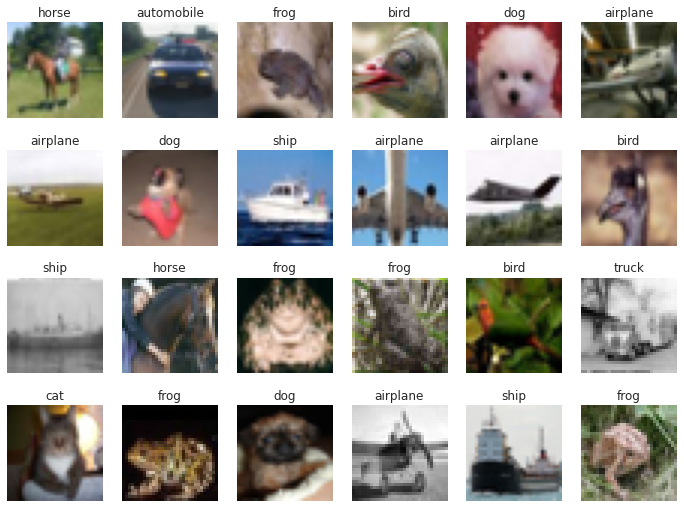

In [12]:
cols = 6
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 9))

for x in range(rows):
    for y in range(cols):
        rnd_idx = randrange(len(trainset.data))
        
        axs[x, y].set_title(IDX_TO_LABEL[trainset.targets[rnd_idx]])
        axs[x, y].imshow(trainset.data[rnd_idx])
        axs[x, y].set_axis_off()

plt.show()    

## Dataset distribution

The balancement of the dataset is a fundamental aspect in designing machine learning algorithms. Each class should contain the same number of examples for the dataset to be perfectly balanced. 

The charts below show the distribution of the 10 classes, both in the train and test set.

### Training set

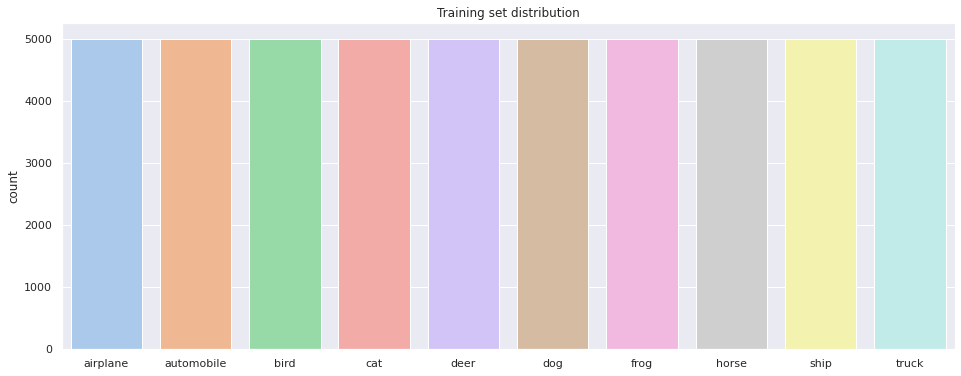

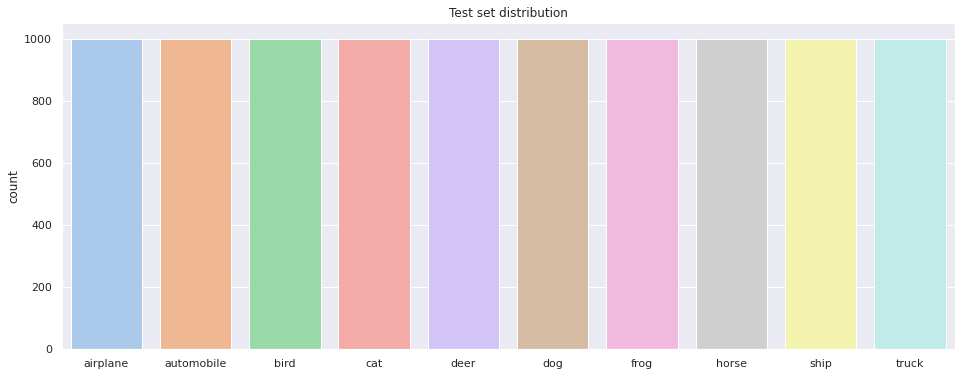

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(trainset.targets).map(IDX_TO_LABEL), 
    order=IDX_TO_LABEL.values(),
).set_title('Training set distribution')

plt.show()

fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(testset.targets).map(IDX_TO_LABEL), 
    order=IDX_TO_LABEL.values(),
).set_title('Test set distribution')

plt.show()

### Test set

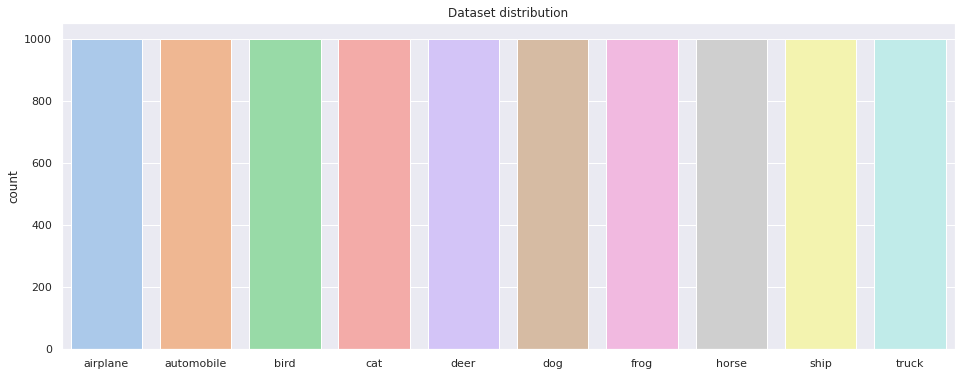

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(testset.targets).map(IDX_TO_LABEL), 
    order=IDX_TO_LABEL.values(),
).set_title('Dataset distribution')

plt.show()

# CNN

The **convolutional neural networks** (CNNs) are a class of **artificial neural networks** (ANNs), most commonly used to perform vision tasks, such as image classification. In this section we're gonna see how good a CNN can perform in the images classification task. 

## Network design

The design of the network is ResNet like, with convolutional layers alternating with residual blocks, and a single fully connected layer attached at the end for the classification. This type of network has been shown to work really well for image classification tasks, such as the one we are trying to challenge. 

After each convolution a Batch normalization is applied, a method to regularize the network that can also decrease training time. This technique has been shown to be far more effective than dropout and has replaced it in many modern convolutional architectures.

It is inspired by this series of blog posts:
https://myrtle.ai/learn/how-to-train-your-resnet/.

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        ), nn.Sequential( 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), 
            nn.Flatten(), 
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.classifier(x)
        
        return x

## Network structure

In [ ]:
# The batch_size is just for reference, since the real size will be 
# adjusted later through hyperparameters optimization

net = ResNet()
net = net.to(device)

summary(net, (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,792
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4          [32, 128, 32, 32]          73,856
       BatchNorm2d-5          [32, 128, 32, 32]             256
              ReLU-6          [32, 128, 32, 32]               0
         MaxPool2d-7          [32, 128, 16, 16]               0
            Conv2d-8          [32, 128, 16, 16]         147,584
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,584
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
           Conv2d-14          [32, 256,

## Functions

In this section we will define some useful functions to wrap the main operations code.

### Dataloaders

It is necessary to split the training set into the `trainloader` and `validloader`, in order to compute some metrics over the validation set. This split is made in accordance to `VALID_SIZE`. A sampler for the training and validation will be computed and used later during DataLoaders creation.

In [ ]:
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
TRAIN_SAMPLER = SubsetRandomSampler(train_idx)
VALID_SAMPLER = SubsetRandomSampler(valid_idx)

The function `data_loaders` creates a DataLoader for the `trainset` the `validationset` and the `testset`. A DataLoader is simply an iterable that abstracts the concept of minibatches, very useful while training a network.

It also apply the `transform` defined in the data collection section.

In [ ]:
# number of subprocesses to use for data loading
NUM_WORKERS = 2

def data_loaders(trainset, validationset, testset, size):
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=size, 
        sampler=TRAIN_SAMPLER, num_workers=NUM_WORKERS
    )
    validloader = torch.utils.data.DataLoader(
        validationset, batch_size=size, 
        sampler=VALID_SAMPLER, num_workers=NUM_WORKERS
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=size, num_workers=NUM_WORKERS
    )

    return trainloader, validloader, testloader

### Train CIFAR

The function `train_cifar`, then, define the training process of the network. Since it will be invoked also in the hyperparameters tuning phase, a keyword argument `tuning` has been added, to customize some specific behaviours. 

It goes through the `trainloader` first, for the training phase and the `validloader` next, for computing validation loss and accuracy at each epoch: these metrics will be used to evaluate and save the best model trained parameters.   

Some important choices:
* CrossEntropyLoss as the loss function
* Adam optimizer, with the specific parameters set later in the hp tuning section

In [ ]:
def train_cifar(
    config, trainset, validationset, testset, 
    epochs=10, checkpoint_dir=None, tuning=False
):
    net = ResNet()
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        net.parameters(), 
        lr=config['lr'], 
        betas=(config['beta1'], config['beta2']), 
        amsgrad=config['amsgrad'], 
    )

    # The `checkpoint_dir` parameter gets passed by Ray Tune when a checkpoint
    # should be restored
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, 'checkpoint')
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader, validloader, testloader = data_loaders(
        trainset, validationset, testset, config['batch_size']
    )

    train_loss_list = []
    accuracy_list = []

    # track minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(epochs):
        
        train_loss = 0.0
        net.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        correct = 0
        valid_loss = 0.0
        net.eval()
        for inputs, labels in validloader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = torch.max(outputs.data, 1)[1]

                correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(TRAIN_SAMPLER)
        valid_loss = valid_loss / len(VALID_SAMPLER)
        accuracy = correct / len(VALID_SAMPLER)

        train_loss_list.append(train_loss)
        accuracy_list.append(accuracy)

        if not tuning:
            print(
                f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \t'
                f'Validation Loss: {valid_loss:.6f} \t'
                f'Validation Accuracy: {accuracy:.6f}'
            )

            if valid_loss <= valid_loss_min:
                print(
                    'Validation loss decreased ('
                    f'{valid_loss_min:.6f} --> {valid_loss:.6f}).  '
                    'Saving model ...'
                )

                torch.save(net.state_dict(), 'cnn.pt')
                valid_loss_min = valid_loss
        else:
            # Here we save a checkpoint. It is automatically registered with
            # Ray Tune and will potentially be passed as the `checkpoint_dir`
            # parameter in future iterations.
            with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((net.state_dict(), optimizer.state_dict()), path)

            tune.report(mean_loss=valid_loss, accuracy=accuracy)

    print(f'\n{color.bold}----------- Finished Training -----------{color.end}')

    return train_loss_list, accuracy_list

### Evaluation

In [ ]:
def test_accuracy(net, testloader):
    correct = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.max(outputs.data, 1)[1]

            correct += (predicted == labels).sum().item()
    
    return correct / len(testloader.dataset)

In [ ]:
def test_accuracy_per_class(net, testloader):
    correct_pred = {classname: 0 for classname in trainset.classes}
    total_pred = {classname: 0 for classname in trainset.classes}

    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            predicted = torch.max(outputs.data, 1)[1]

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[trainset.classes[label]] += 1
                total_pred[trainset.classes[label]] += 1
    
    accuracy_per_class = {classname: 0 for classname in trainset.classes}
    for classname, correct_count in correct_pred.items():
        accuracy = (100 * float(correct_count)) / total_pred[classname]
        accuracy_per_class[classname] = accuracy

    return accuracy_per_class

## Hyperparameters tuning

For the hyperparameters tuning has been decided to use Ray Tune. 

The search space involves the:
* `batch_size`
* `lr`, learning rate
* `beta1` and `beta2` coefficients, used for computing running averages of gradient and its square (Adam optimizer)
* `amsgrad`, a boolean indicating whether to use the AMSGrad variant of Adam or not, from the paper: [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ).

The search algorithm used is **BOHB (Bayesian Optimization HyperBand)**:
> BOHB (Bayesian Optimization HyperBand) is an algorithm that both terminates bad trials and also uses Bayesian Optimization to improve the hyperparameter search.

It must be paired with a specific scheduler class: **HyperBandForBOHB**. 

In [ ]:
config = {
    'batch_size': tune.choice([16, 32, 128]),
    'lr': tune.loguniform(1e-6, 1e-2),
    'beta1': tune.uniform(0.8, 0.96),
    'beta2': tune.uniform(0.98, 0.999999),
    'amsgrad': tune.choice([True, False]),
}

search_alg = TuneBOHB(metric="mean_loss", mode="min")
scheduler = HyperBandForBOHB(
    time_attr='training_iteration',
    metric='mean_loss',
    mode='min',
    max_t=100
)
reporter = CLIReporter(
    metric_columns=['mean_loss', 'accuracy', 'training_iteration'],
    metric='mean_loss',
    mode='min',
    sort_by_metric=True
)

result = tune.run(
    tune.with_parameters(
        train_cifar, 
        tuning=True, 
        trainset=trainset, 
        validationset=validationset, 
        testset=testset
    ),
    num_samples=30,
    resources_per_trial={'gpu': 1},
    scheduler=scheduler,
    config=config,
    search_alg=search_alg,    
    progress_reporter=reporter
)

2022-07-14 13:33:54,555	INFO logger.py:630 -- pip install "ray[tune]" to see TensorBoard files.
2022-07-14 13:33:54,557	WARNING callback.py:106 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2022-07-14 13:33:54 (running for 00:00:00.28)
Memory usage on this node: 3.9/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.0%): {RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 1/30 (1 RUNNING)
+----------------------+----------+----------------+-----------+--------------+----------+----------+-------------+
| Trial name           | status   | loc            | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |
|----------------------+----------+----------------+-----------+--------------+----------+----------+-------------|
| train_cifar_9b19ea40 | RUNNING  | 172.28.0.2:393 | True      |           32 | 0.807974 | 0.988148 | 9.48461e-06 |
+----------------------+----------+----------------+-----------+-----------

(train_cifar pid=393) 2022-07-14 13:34:31,270	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:34:32 (running for 00:00:37.78)
Memory usage on this node: 3.9/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.2%): {PAUSED: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: 9b19ea40 with mean_loss=1.2341617997169494 and parameters={'batch_size': 32, 'lr': 9.484609102869304e-06, 'beta1': 0.8079736943324188, 'beta2': 0.9881484339246728, 'amsgrad': True}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 2/30 (1 PAUSED, 1 RUNNING)
+----------------------+----------+----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc            | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |   accuracy |   traini

(train_cifar pid=470) 2022-07-14 13:35:02,787	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:35:08 (running for 00:01:13.80)
Memory usage on this node: 5.6/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.5%): {PAUSED: 2, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: 9c71a540 with mean_loss=1.04626914768219 and parameters={'batch_size': 128, 'lr': 5.567170454262844e-05, 'beta1': 0.8435821307780147, 'beta2': 0.9874920327114979, 'amsgrad': True}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 4/30 (2 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc            | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |

(train_cifar pid=546) 2022-07-14 13:35:33,213	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:35:34 (running for 00:01:39.79)
Memory usage on this node: 4.0/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.7%): {PAUSED: 3, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: b2e54c78 with mean_loss=0.9295899567604065 and parameters={'batch_size': 128, 'lr': 0.00011886959463512295, 'beta1': 0.8636808166075834, 'beta2': 0.9946944549454401, 'amsgrad': True}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 4/30 (3 PAUSED, 1 RUNNING)
+----------------------+----------+----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc            | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |   accuracy |   trai

(train_cifar pid=623) 2022-07-14 13:36:24,468	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:36:30 (running for 00:02:35.82)
Memory usage on this node: 5.8/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=1.0%): {PAUSED: 4, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: c40c1f18 with mean_loss=0.8897911108016968 and parameters={'batch_size': 16, 'lr': 0.000958135411512331, 'beta1': 0.9491348338072463, 'beta2': 0.9998717556813997, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 6/30 (4 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc            | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss 

(train_cifar pid=707) 2022-07-14 13:37:15,129	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:37:20 (running for 00:03:25.82)
Memory usage on this node: 5.7/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=1.2%): {PAUSED: 5, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: c40c1f18 with mean_loss=0.8897911108016968 and parameters={'batch_size': 16, 'lr': 0.000958135411512331, 'beta1': 0.9491348338072463, 'beta2': 0.9998717556813997, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 7/30 (5 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc            | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss 

(train_cifar pid=791) 2022-07-14 13:38:06,340	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:38:12 (running for 00:04:17.82)
Memory usage on this node: 5.9/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=1.5%): {PAUSED: 6, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 8/30 (6 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc            | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_los

(train_cifar pid=875) 2022-07-14 13:38:57,354	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:38:58 (running for 00:05:03.82)
Memory usage on this node: 4.6/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=1.7%): {PAUSED: 7, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 8/30 (7 PAUSED, 1 RUNNING)
+----------------------+----------+----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc            | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |   accuracy |   trai

(train_cifar pid=957) 2022-07-14 13:39:49,213	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:39:54 (running for 00:05:59.86)
Memory usage on this node: 6.5/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=2.0%): {PAUSED: 8, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 10/30 (8 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_

(train_cifar pid=1041) 2022-07-14 13:40:25,990	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:40:31 (running for 00:06:36.86)
Memory usage on this node: 6.9/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=2.2%): {PAUSED: 9, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 11/30 (9 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_

(train_cifar pid=1119) 2022-07-14 13:40:56,464	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:40:57 (running for 00:07:02.85)
Memory usage on this node: 5.4/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=2.5%): {PAUSED: 10, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 11/30 (10 PAUSED, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |   accuracy |  

(train_cifar pid=1194) 2022-07-14 13:41:34,157	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:41:39 (running for 00:07:44.90)
Memory usage on this node: 7.3/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=2.7%): {PAUSED: 11, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 13/30 (11 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1272) 2022-07-14 13:42:11,302	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:42:16 (running for 00:08:22.00)
Memory usage on this node: 7.4/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=3.0%): {PAUSED: 12, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 14/30 (12 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1349) 2022-07-14 13:42:48,049	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:42:53 (running for 00:08:58.89)
Memory usage on this node: 7.6/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=3.2%): {PAUSED: 13, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 15/30 (13 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1427) 2022-07-14 13:43:38,484	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:43:39 (running for 00:09:44.90)
Memory usage on this node: 6.0/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=3.5%): {PAUSED: 14, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 15/30 (14 PAUSED, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |   accuracy |  

(train_cifar pid=1508) 2022-07-14 13:44:30,214	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:44:35 (running for 00:10:41.07)
Memory usage on this node: 7.7/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=3.7%): {PAUSED: 15, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 17/30 (15 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1594) 2022-07-14 13:45:07,551	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:45:13 (running for 00:11:19.03)
Memory usage on this node: 7.8/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=4.0%): {PAUSED: 16, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 18/30 (16 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1673) 2022-07-14 13:45:45,477	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:45:51 (running for 00:11:57.05)
Memory usage on this node: 7.9/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=4.2%): {PAUSED: 17, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 19/30 (17 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1750) 2022-07-14 13:46:23,811	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:46:29 (running for 00:12:35.06)
Memory usage on this node: 8.0/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=4.4%): {PAUSED: 18, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 20/30 (18 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1828) 2022-07-14 13:46:54,957	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:47:00 (running for 00:13:06.06)
Memory usage on this node: 8.0/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=4.7%): {PAUSED: 19, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 21/30 (19 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1903) 2022-07-14 13:47:33,075	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:47:38 (running for 00:13:44.08)
Memory usage on this node: 8.2/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=4.9%): {PAUSED: 20, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 22/30 (20 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=1980) 2022-07-14 13:48:24,811	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:48:30 (running for 00:14:36.10)
Memory usage on this node: 8.2/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=5.2%): {PAUSED: 21, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 23/30 (21 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=2063) 2022-07-14 13:48:55,724	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:49:01 (running for 00:15:07.10)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=5.4%): {PAUSED: 22, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 24/30 (22 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=2139) 2022-07-14 13:49:47,846	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:49:53 (running for 00:15:59.11)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=5.7%): {PAUSED: 23, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.7705211903810502 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 25/30 (23 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mea

(train_cifar pid=2222) 2022-07-14 13:50:38,995	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:50:44 (running for 00:16:50.05)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=5.9%): {PAUSED: 24, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: b4ae9c88 with mean_loss=0.7385404561042785 and parameters={'batch_size': 16, 'lr': 0.00021509671689140438, 'beta1': 0.8909532711047851, 'beta2': 0.989392180051214, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 26/30 (24 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean

(train_cifar pid=2305) 2022-07-14 13:51:29,887	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:51:30 (running for 00:17:35.44)
Memory usage on this node: 8.8/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=6.2%): {PAUSED: 25, PENDING: 1} 
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 26/30 (25 PAUSED, 1 PENDING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |   accuracy |   trai

(train_cifar pid=2386) 2022-07-14 13:52:21,198	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:52:26 (running for 00:18:32.15)
Memory usage on this node: 8.6/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=6.4%): {PAUSED: 26, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 28/30 (26 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean

(train_cifar pid=2469) 2022-07-14 13:52:58,292	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:53:03 (running for 00:19:09.10)
Memory usage on this node: 8.7/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=6.7%): {PAUSED: 27, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 29/30 (27 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean

(train_cifar pid=2548) 2022-07-14 13:53:35,539	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:53:41 (running for 00:19:47.19)
Memory usage on this node: 8.8/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=6.9%): {PAUSED: 28, PENDING: 1, RUNNING: 1} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (28 PAUSED, 1 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean

(train_cifar pid=2624) 2022-07-14 13:54:07,006	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 13:54:07 (running for 00:20:12.51)
Memory usage on this node: 9.3/12.7 GiB
Using HyperBand: num_stopped=0 total_brackets=1
Round #0:
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=7.2%): {PAUSED: 29, PENDING: 1} 
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (29 PAUSED, 1 PENDING)
+----------------------+----------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status   | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |   accuracy |   trai

(train_cifar pid=2703) 2022-07-14 13:54:44,544	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


Result for train_cifar_6e8baa76:
  accuracy: 0.384
  date: 2022-07-14_13-40-56
  done: false
  experiment_id: 8d771cfbc92341089edca9d22b0fd66c
  experiment_tag: 10_amsgrad=False,batch_size=128,beta1=0.8037,beta2=0.9990,lr=0.0000
  hostname: 9b92816139ef
  iterations_since_restore: 1
  mean_loss: 1.7257425029754638
  neg_mean_loss: -1.7257425029754638
  node_ip: 172.28.0.2
  pid: 1119
  should_checkpoint: true
  time_since_restore: 27.75054121017456
  time_this_iter_s: 27.75054121017456
  time_total_s: 27.75054121017456
  timestamp: 1657806056
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6e8baa76
  warmup_time: 0.003024578094482422
  
Result for train_cifar_12bd131a:
  accuracy: 0.4498
  date: 2022-07-14_13-38-57
  done: false
  experiment_id: 806e8ae8abfd47b58ab91d549a0efd10
  experiment_tag: 7_amsgrad=False,batch_size=16,beta1=0.8594,beta2=0.9822,lr=0.0000
  hostname: 9b92816139ef
  iterations_since_restore: 1
  mean_loss: 1.575149186706543
  neg_mean_loss: -1.5751

(train_cifar pid=2781) 2022-07-14 13:54:48,027	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_9b19ea40_1_amsgrad=True,batch_size=32,beta1=0.8080,beta2=0.9881,lr=0.0000_2022-07-14_13-33-54/checkpoint_tmpa0982a/./
(train_cifar pid=2781) 2022-07-14 13:54:48,027	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.112809896469116, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 13:54:50 (running for 00:20:56.11)
Memory usage on this node: 8.7/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=7.4%): {PENDING: 26, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (26 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |         

(train_cifar pid=2781) 2022-07-14 13:55:54,038	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=2891) 2022-07-14 13:55:57,131	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_9c71a540_2_amsgrad=True,batch_size=128,beta1=0.8436,beta2=0.9875,lr=0.0001_2022-07-14_13-34-32/checkpoint_tmpf12b56/./
(train_cifar pid=2891) 2022-07-14 13:55:57,131	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 27.947655200958252, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 13:55:59 (running for 00:22:05.17)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=7.9%): {PAUSED: 1, PENDING: 25, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (1 PAUSED, 25 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 

(train_cifar pid=2891) 2022-07-14 13:56:50,257	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:56:50 (running for 00:22:56.17)
Memory usage on this node: 7.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=8.4%): {PAUSED: 2, PENDING: 24, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (2 PAUSED, 24 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 

(train_cifar pid=2996) 2022-07-14 13:56:53,089	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_b2e54c78_3_amsgrad=True,batch_size=128,beta1=0.8637,beta2=0.9947,lr=0.0001_2022-07-14_13-35-03/checkpoint_tmp5d2217/./
(train_cifar pid=2996) 2022-07-14 13:56:53,089	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 27.488394260406494, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 13:56:55 (running for 00:23:01.18)
Memory usage on this node: 8.8/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=8.4%): {PAUSED: 2, PENDING: 24, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (2 PAUSED, 24 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 

(train_cifar pid=2996) 2022-07-14 13:57:45,788	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 13:57:46 (running for 00:23:52.17)
Memory usage on this node: 7.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=8.9%): {PAUSED: 3, PENDING: 23, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (3 PAUSED, 23 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 

(train_cifar pid=3091) 2022-07-14 13:57:49,065	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_c40c1f18_4_amsgrad=False,batch_size=16,beta1=0.9491,beta2=0.9999,lr=0.0010_2022-07-14_13-35-34/checkpoint_tmp07f15b/./
(train_cifar pid=3091) 2022-07-14 13:57:49,065	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 47.715845584869385, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 13:57:51 (running for 00:23:57.19)
Memory usage on this node: 8.8/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=8.9%): {PAUSED: 3, PENDING: 23, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: d3af382c with mean_loss=0.7092630754947662 and parameters={'batch_size': 16, 'lr': 0.0002683025058638061, 'beta1': 0.9302006667285799, 'beta2': 0.9903805870305792, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (3 PAUSED, 23 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 

(train_cifar pid=3091) 2022-07-14 13:59:28,162	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=3204) 2022-07-14 13:59:31,116	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_d7d122dc_5_amsgrad=False,batch_size=16,beta1=0.8338,beta2=0.9936,lr=0.0000_2022-07-14_13-36-25/checkpoint_tmpa3e1b4/./
(train_cifar pid=3204) 2022-07-14 13:59:31,116	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 47.49173665046692, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 13:59:33 (running for 00:25:39.23)
Memory usage on this node: 8.9/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=9.4%): {PAUSED: 4, PENDING: 22, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: c40c1f18 with mean_loss=0.4984618887603283 and parameters={'batch_size': 16, 'lr': 0.000958135411512331, 'beta1': 0.9491348338072463, 'beta2': 0.9998717556813997, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (4 PAUSED, 22 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |

(train_cifar pid=3204) 2022-07-14 14:01:03,787	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 14:01:04 (running for 00:27:10.25)
Memory usage on this node: 7.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=9.9%): {PAUSED: 5, PENDING: 21, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: c40c1f18 with mean_loss=0.4984618887603283 and parameters={'batch_size': 16, 'lr': 0.000958135411512331, 'beta1': 0.9491348338072463, 'beta2': 0.9998717556813997, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (5 PAUSED, 21 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |

(train_cifar pid=3319) 2022-07-14 14:01:07,067	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_f4ed9508_6_amsgrad=False,batch_size=16,beta1=0.9018,beta2=0.9897,lr=0.0002_2022-07-14_13-37-15/checkpoint_tmpf23163/./
(train_cifar pid=3319) 2022-07-14 14:01:07,068	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 48.58105969429016, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:01:09 (running for 00:27:15.27)
Memory usage on this node: 8.9/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=9.9%): {PAUSED: 5, PENDING: 21, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: c40c1f18 with mean_loss=0.4984618887603283 and parameters={'batch_size': 16, 'lr': 0.000958135411512331, 'beta1': 0.9491348338072463, 'beta2': 0.9998717556813997, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (5 PAUSED, 21 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |

(train_cifar pid=3319) 2022-07-14 14:02:40,241	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 14:02:40 (running for 00:28:46.29)
Memory usage on this node: 7.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=10.4%): {PAUSED: 6, PENDING: 20, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (6 PAUSED, 20 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=3430) 2022-07-14 14:02:43,964	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_31bc67d4_8_amsgrad=True,batch_size=16,beta1=0.8906,beta2=0.9876,lr=0.0002_2022-07-14_13-38-58/checkpoint_tmpf7c4b3/./
(train_cifar pid=3430) 2022-07-14 14:02:43,964	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 48.455331563949585, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:02:45 (running for 00:28:51.33)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=10.4%): {PAUSED: 6, PENDING: 20, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (6 PAUSED, 20 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=3430) 2022-07-14 14:04:18,904	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=3551) 2022-07-14 14:04:22,214	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_849b1fcc_11_amsgrad=True,batch_size=32,beta1=0.9273,beta2=0.9975,lr=0.0001_2022-07-14_13-40-57/checkpoint_tmpc62c1a/./
(train_cifar pid=3551) 2022-07-14 14:04:22,215	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.39342474937439, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:04:24 (running for 00:30:30.32)
Memory usage on this node: 8.8/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=10.9%): {PAUSED: 7, PENDING: 19, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (7 PAUSED, 19 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=3551) 2022-07-14 14:05:31,149	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=3661) 2022-07-14 14:05:34,183	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_9850fe9c_12_amsgrad=False,batch_size=32,beta1=0.9488,beta2=0.9955,lr=0.0006_2022-07-14_13-41-34/checkpoint_tmp876d82/./
(train_cifar pid=3661) 2022-07-14 14:05:34,183	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.260040521621704, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:05:36 (running for 00:31:42.35)
Memory usage on this node: 8.9/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=11.4%): {PAUSED: 8, PENDING: 18, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (8 PAUSED, 18 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=3661) 2022-07-14 14:06:39,279	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=3765) 2022-07-14 14:06:42,191	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_ad29556c_13_amsgrad=False,batch_size=32,beta1=0.8582,beta2=0.9915,lr=0.0000_2022-07-14_13-42-11/checkpoint_tmp41ec96/./
(train_cifar pid=3765) 2022-07-14 14:06:42,191	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.17211651802063, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:06:44 (running for 00:32:50.37)
Memory usage on this node: 8.9/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=11.9%): {PAUSED: 9, PENDING: 17, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (9 PAUSED, 17 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=3765) 2022-07-14 14:07:48,750	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=3862) 2022-07-14 14:07:51,374	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_c33520a2_14_amsgrad=False,batch_size=16,beta1=0.9342,beta2=0.9967,lr=0.0036_2022-07-14_13-42-48/checkpoint_tmp8b5c59/./
(train_cifar pid=3862) 2022-07-14 14:07:51,375	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 47.73537063598633, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:07:53 (running for 00:33:59.42)
Memory usage on this node: 8.8/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=12.3%): {PAUSED: 10, PENDING: 16, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (10 PAUSED, 16 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=3862) 2022-07-14 14:09:25,225	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 14:09:26 (running for 00:35:31.45)
Memory usage on this node: 7.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=12.8%): {PAUSED: 11, PENDING: 15, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (11 PAUSED, 15 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=3967) 2022-07-14 14:09:28,304	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_d9431d36_15_amsgrad=False,batch_size=16,beta1=0.8032,beta2=0.9957,lr=0.0006_2022-07-14_13-43-39/checkpoint_tmp62ca35/./
(train_cifar pid=3967) 2022-07-14 14:09:28,304	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 48.4515061378479, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:09:31 (running for 00:35:36.46)
Memory usage on this node: 8.8/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=12.8%): {PAUSED: 11, PENDING: 15, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (11 PAUSED, 15 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=3967) 2022-07-14 14:11:01,512	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 14:11:02 (running for 00:37:07.47)
Memory usage on this node: 7.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=13.3%): {PAUSED: 12, PENDING: 14, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (12 PAUSED, 14 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=4072) 2022-07-14 14:11:04,460	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_f8ec8fe6_16_amsgrad=True,batch_size=32,beta1=0.9246,beta2=1.0000,lr=0.0001_2022-07-14_13-44-30/checkpoint_tmp0b2030/./
(train_cifar pid=4072) 2022-07-14 14:11:04,461	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.62360858917236, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:11:07 (running for 00:37:12.50)
Memory usage on this node: 8.7/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=13.3%): {PAUSED: 12, PENDING: 14, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (12 PAUSED, 14 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=4072) 2022-07-14 14:12:10,598	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=4172) 2022-07-14 14:12:13,416	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_161b8996_17_amsgrad=True,batch_size=32,beta1=0.9517,beta2=0.9992,lr=0.0000_2022-07-14_13-45-08/checkpoint_tmp32e2d8/./
(train_cifar pid=4172) 2022-07-14 14:12:13,416	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.63940691947937, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:12:16 (running for 00:38:21.51)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=13.8%): {PAUSED: 13, PENDING: 13, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (13 PAUSED, 13 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=4172) 2022-07-14 14:13:18,976	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=4269) 2022-07-14 14:13:22,455	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_2cbe9ad0_18_amsgrad=True,batch_size=32,beta1=0.9357,beta2=0.9973,lr=0.0002_2022-07-14_13-45-46/checkpoint_tmp35ffa2/./
(train_cifar pid=4269) 2022-07-14 14:13:22,455	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.92383646965027, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:13:25 (running for 00:39:30.55)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=14.3%): {PAUSED: 14, PENDING: 12, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (14 PAUSED, 12 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=4269) 2022-07-14 14:14:28,364	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=4370) 2022-07-14 14:14:31,517	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_4367a2ea_19_amsgrad=False,batch_size=128,beta1=0.9184,beta2=0.9865,lr=0.0003_2022-07-14_13-46-24/checkpoint_tmpb97fa0/./
(train_cifar pid=4370) 2022-07-14 14:14:31,517	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 28.112428426742554, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:14:34 (running for 00:40:39.59)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=14.8%): {PAUSED: 15, PENDING: 11, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (15 PAUSED, 11 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=4370) 2022-07-14 14:15:23,728	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=4465) 2022-07-14 14:15:26,524	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_5a0fcd56_20_amsgrad=True,batch_size=32,beta1=0.8956,beta2=0.9845,lr=0.0003_2022-07-14_13-46-55/checkpoint_tmp28f5be/./
(train_cifar pid=4465) 2022-07-14 14:15:26,524	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 35.0727322101593, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:15:29 (running for 00:41:34.61)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=15.3%): {PAUSED: 16, PENDING: 10, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (16 PAUSED, 10 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    b

(train_cifar pid=4465) 2022-07-14 14:16:32,131	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=4563) 2022-07-14 14:16:35,483	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_6c8adde0_21_amsgrad=True,batch_size=16,beta1=0.9098,beta2=0.9864,lr=0.0002_2022-07-14_13-47-33/checkpoint_tmp538481/./
(train_cifar pid=4563) 2022-07-14 14:16:35,483	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 48.92216730117798, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:16:38 (running for 00:42:43.64)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=15.8%): {PAUSED: 17, PENDING: 9, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (17 PAUSED, 9 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=4563) 2022-07-14 14:18:10,007	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes


== Status ==
Current time: 2022-07-14 14:18:10 (running for 00:44:15.73)
Memory usage on this node: 7.2/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=16.3%): {PAUSED: 18, PENDING: 8, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (18 PAUSED, 8 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=4666) 2022-07-14 14:18:12,579	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_8332b7fc_22_amsgrad=False,batch_size=128,beta1=0.9296,beta2=0.9843,lr=0.0002_2022-07-14_13-48-25/checkpoint_tmp36b345/./
(train_cifar pid=4666) 2022-07-14 14:18:12,579	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 27.874440670013428, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:18:15 (running for 00:44:20.75)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=16.3%): {PAUSED: 18, PENDING: 8, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (18 PAUSED, 8 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=4666) 2022-07-14 14:19:04,891	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=4761) 2022-07-14 14:19:07,564	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_a2336566_23_amsgrad=True,batch_size=16,beta1=0.8978,beta2=0.9860,lr=0.0003_2022-07-14_13-48-56/checkpoint_tmp43eb2a/./
(train_cifar pid=4761) 2022-07-14 14:19:07,565	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 48.946102142333984, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:19:10 (running for 00:45:15.68)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=16.8%): {PAUSED: 19, PENDING: 7, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (19 PAUSED, 7 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=4761) 2022-07-14 14:20:42,645	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=4865) 2022-07-14 14:20:45,499	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_b4ae9c88_24_amsgrad=False,batch_size=16,beta1=0.8910,beta2=0.9894,lr=0.0002_2022-07-14_13-49-48/checkpoint_tmpbea7ab/./
(train_cifar pid=4865) 2022-07-14 14:20:45,499	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 48.09874439239502, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:20:48 (running for 00:46:53.74)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=17.3%): {PAUSED: 20, PENDING: 6, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (20 PAUSED, 6 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=4865) 2022-07-14 14:22:18,607	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 14:22:19 (running for 00:48:24.77)
Memory usage on this node: 7.1/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=17.8%): {PAUSED: 21, PENDING: 5, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (21 PAUSED, 5 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=4968) 2022-07-14 14:22:21,576	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_d3af382c_25_amsgrad=False,batch_size=16,beta1=0.9302,beta2=0.9904,lr=0.0003_2022-07-14_13-50-39/checkpoint_tmp9aa3dc/./
(train_cifar pid=4968) 2022-07-14 14:22:21,576	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 48.07502198219299, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:22:24 (running for 00:48:29.78)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=17.8%): {PAUSED: 21, PENDING: 5, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (21 PAUSED, 5 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=4968) 2022-07-14 14:23:54,868	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=5074) 2022-07-14 14:23:57,602	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_f217bda2_26_amsgrad=False,batch_size=16,beta1=0.9412,beta2=0.9970,lr=0.0000_2022-07-14_13-51-30/checkpoint_tmp4734dc/./
(train_cifar pid=5074) 2022-07-14 14:23:57,602	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 48.16523027420044, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:24:00 (running for 00:50:05.79)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=18.3%): {PAUSED: 22, PENDING: 4, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (22 PAUSED, 4 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=5074) 2022-07-14 14:25:30,903	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=5177) 2022-07-14 14:25:33,678	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_107fb092_27_amsgrad=False,batch_size=32,beta1=0.9439,beta2=0.9933,lr=0.0004_2022-07-14_13-52-21/checkpoint_tmpd041ee/./
(train_cifar pid=5177) 2022-07-14 14:25:33,679	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.26399278640747, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:25:36 (running for 00:51:41.83)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=18.8%): {PAUSED: 23, PENDING: 3, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (23 PAUSED, 3 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=5177) 2022-07-14 14:26:38,584	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=5275) 2022-07-14 14:26:41,657	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_2ee7892e_28_amsgrad=False,batch_size=32,beta1=0.9066,beta2=0.9888,lr=0.0002_2022-07-14_13-52-58/checkpoint_tmp5e0ef8/./
(train_cifar pid=5275) 2022-07-14 14:26:41,658	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.52212190628052, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:26:44 (running for 00:52:49.88)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=19.3%): {PAUSED: 24, PENDING: 2, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (24 PAUSED, 2 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=5275) 2022-07-14 14:27:47,093	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=5372) 2022-07-14 14:27:49,704	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_44f8c08e_29_amsgrad=False,batch_size=128,beta1=0.8581,beta2=0.9833,lr=0.0058_2022-07-14_13-53-36/checkpoint_tmp60b1d9/./
(train_cifar pid=5372) 2022-07-14 14:27:49,704	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 28.062349557876587, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:27:52 (running for 00:53:57.89)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=19.8%): {PAUSED: 25, PENDING: 1, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (25 PAUSED, 1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    bet

(train_cifar pid=5372) 2022-07-14 14:28:42,223	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=5467) 2022-07-14 14:28:44,802	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_5ba05bd0_30_amsgrad=False,batch_size=32,beta1=0.8941,beta2=0.9909,lr=0.0002_2022-07-14_13-54-07/checkpoint_tmpc075e5/./
(train_cifar pid=5467) 2022-07-14 14:28:44,802	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 34.62060737609863, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:28:47 (running for 00:54:52.91)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=3 total_brackets=1
Round #0:
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.2%): {PAUSED: 26, RUNNING: 1, TERMINATED: 3} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (26 PAUSED, 1 RUNNING, 3 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |        

(train_cifar pid=5558) 2022-07-14 14:29:52,708	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_c40c1f18_4_amsgrad=False,batch_size=16,beta1=0.9491,beta2=0.9999,lr=0.0010_2022-07-14_13-35-34/checkpoint_tmpc9098e/./
(train_cifar pid=5558) 2022-07-14 14:29:52,708	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 146.56857466697693, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:29:55 (running for 00:56:01.00)
Memory usage on this node: 8.6/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=20.7%): {PENDING: 8, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.48915878913402555 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (8 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |      

(train_cifar pid=5558) 2022-07-14 14:34:24,898	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 14:34:25 (running for 01:00:31.02)
Memory usage on this node: 7.1/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=22.2%): {PAUSED: 1, PENDING: 7, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: c40c1f18 with mean_loss=0.3548553883738816 and parameters={'batch_size': 16, 'lr': 0.000958135411512331, 'beta1': 0.9491348338072463, 'beta2': 0.9998717556813997, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (1 PAUSED, 7 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 

(train_cifar pid=5780) 2022-07-14 14:34:28,049	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_f4ed9508_6_amsgrad=False,batch_size=16,beta1=0.9018,beta2=0.9897,lr=0.0002_2022-07-14_13-37-15/checkpoint_tmp3d545e/./
(train_cifar pid=5780) 2022-07-14 14:34:28,049	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 141.49890542030334, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:34:30 (running for 01:00:36.03)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=22.2%): {PAUSED: 1, PENDING: 7, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: c40c1f18 with mean_loss=0.3548553883738816 and parameters={'batch_size': 16, 'lr': 0.000958135411512331, 'beta1': 0.9491348338072463, 'beta2': 0.9998717556813997, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (1 PAUSED, 7 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 

(train_cifar pid=5780) 2022-07-14 14:38:59,912	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 14:39:00 (running for 01:05:06.11)
Memory usage on this node: 7.1/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=23.7%): {PAUSED: 2, PENDING: 6, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (2 PAUSED, 6 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1

(train_cifar pid=5998) 2022-07-14 14:39:03,276	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_31bc67d4_8_amsgrad=True,batch_size=16,beta1=0.8906,beta2=0.9876,lr=0.0002_2022-07-14_13-38-58/checkpoint_tmpa79c16/./
(train_cifar pid=5998) 2022-07-14 14:39:03,276	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 143.0981936454773, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:39:05 (running for 01:05:11.14)
Memory usage on this node: 8.3/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=23.7%): {PAUSED: 2, PENDING: 6, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (2 PAUSED, 6 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1

(train_cifar pid=5998) 2022-07-14 14:43:42,046	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=6219) 2022-07-14 14:43:45,259	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_d9431d36_15_amsgrad=False,batch_size=16,beta1=0.8032,beta2=0.9957,lr=0.0006_2022-07-14_13-43-39/checkpoint_tmpac720e/./
(train_cifar pid=6219) 2022-07-14 14:43:45,259	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 141.45354747772217, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:43:47 (running for 01:09:53.20)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=25.2%): {PAUSED: 3, PENDING: 5, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (3 PAUSED, 5 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1

(train_cifar pid=6219) 2022-07-14 14:48:15,773	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes


== Status ==
Current time: 2022-07-14 14:48:16 (running for 01:14:22.31)
Memory usage on this node: 7.2/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=26.7%): {PAUSED: 4, PENDING: 4, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (4 PAUSED, 4 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1

(train_cifar pid=6440) 2022-07-14 14:48:19,275	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_5a0fcd56_20_amsgrad=True,batch_size=32,beta1=0.8956,beta2=0.9845,lr=0.0003_2022-07-14_13-46-55/checkpoint_tmp410e9e/./
(train_cifar pid=6440) 2022-07-14 14:48:19,275	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 100.40139985084534, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:48:21 (running for 01:14:27.33)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=26.7%): {PAUSED: 4, PENDING: 4, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (4 PAUSED, 4 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1

(train_cifar pid=6440) 2022-07-14 14:51:29,825	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=6644) 2022-07-14 14:51:33,294	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_6c8adde0_21_amsgrad=True,batch_size=16,beta1=0.9098,beta2=0.9864,lr=0.0002_2022-07-14_13-47-33/checkpoint_tmp830f2f/./
(train_cifar pid=6644) 2022-07-14 14:51:33,294	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 143.1387333869934, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:51:35 (running for 01:17:41.36)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=28.1%): {PAUSED: 5, PENDING: 3, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (5 PAUSED, 3 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1

(train_cifar pid=6644) 2022-07-14 14:56:12,537	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=6867) 2022-07-14 14:56:15,582	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_a2336566_23_amsgrad=True,batch_size=16,beta1=0.8978,beta2=0.9860,lr=0.0003_2022-07-14_13-48-56/checkpoint_tmp600256/./
(train_cifar pid=6867) 2022-07-14 14:56:15,582	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 143.72747445106506, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 14:56:18 (running for 01:22:23.44)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=29.6%): {PAUSED: 6, PENDING: 2, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (6 PAUSED, 2 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1

(train_cifar pid=6867) 2022-07-14 15:00:54,499	INFO trainable.py:106 -- Checkpoint size is 105281203 bytes
(train_cifar pid=7090) 2022-07-14 15:00:57,480	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_b4ae9c88_24_amsgrad=False,batch_size=16,beta1=0.8910,beta2=0.9894,lr=0.0002_2022-07-14_13-49-48/checkpoint_tmpefcb4d/./
(train_cifar pid=7090) 2022-07-14 15:00:57,480	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 140.9931435585022, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 15:01:00 (running for 01:27:05.52)
Memory usage on this node: 8.6/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=31.1%): {PAUSED: 7, PENDING: 1, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (7 PAUSED, 1 PENDING, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1

(train_cifar pid=7090) 2022-07-14 15:05:32,167	INFO trainable.py:106 -- Checkpoint size is 78970039 bytes
(train_cifar pid=7312) 2022-07-14 15:05:35,404	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_d3af382c_25_amsgrad=False,batch_size=16,beta1=0.9302,beta2=0.9904,lr=0.0003_2022-07-14_13-50-39/checkpoint_tmp48ccd5/./
(train_cifar pid=7312) 2022-07-14 15:05:35,404	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 141.13395071029663, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 15:05:38 (running for 01:31:43.61)
Memory usage on this node: 8.6/12.7 GiB
Using HyperBand: num_stopped=21 total_brackets=1
Round #0:
  Bracket(Max Size (n)=9, Milestone (r)=9, completed=32.6%): {PAUSED: 8, RUNNING: 1, TERMINATED: 21} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (8 PAUSED, 1 RUNNING, 21 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          

(train_cifar pid=7524) 2022-07-14 15:10:13,544	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_f4ed9508_6_amsgrad=False,batch_size=16,beta1=0.9018,beta2=0.9897,lr=0.0002_2022-07-14_13-37-15/checkpoint_tmp4513e3/./
(train_cifar pid=7524) 2022-07-14 15:10:13,544	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 9, '_timesteps_total': None, '_time_total': 413.07320189476013, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 15:10:16 (running for 01:36:21.66)
Memory usage on this node: 8.6/12.7 GiB
Using HyperBand: num_stopped=27 total_brackets=1
Round #0:
  Bracket(Max Size (n)=3, Milestone (r)=27, completed=34.1%): {PENDING: 2, RUNNING: 1, TERMINATED: 27} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.321120310844481 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (2 PENDING, 1 RUNNING, 27 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |       

(train_cifar pid=7857) 2022-07-14 15:17:54,872	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_6c8adde0_21_amsgrad=True,batch_size=16,beta1=0.9098,beta2=0.9864,lr=0.0002_2022-07-14_13-47-33/checkpoint_tmp4de333/./
(train_cifar pid=7857) 2022-07-14 15:17:54,872	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 9, '_timesteps_total': None, '_time_total': 422.0328896045685, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 15:17:57 (running for 01:44:02.80)
Memory usage on this node: 8.5/12.7 GiB
Using HyperBand: num_stopped=27 total_brackets=1
Round #0:
  Bracket(Max Size (n)=3, Milestone (r)=27, completed=36.5%): {PENDING: 1, RUNNING: 1, TERMINATED: 28} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: f4ed9508 with mean_loss=0.30427060941271483 and parameters={'batch_size': 16, 'lr': 0.00015993227425983896, 'beta1': 0.9018448945921761, 'beta2': 0.9897154281343777, 'amsgrad': False}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (1 PENDING, 1 RUNNING, 28 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |     

(train_cifar pid=8194) 2022-07-14 15:25:49,283	INFO trainable.py:589 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/train_cifar_2022-07-14_13-33-54/train_cifar_a2336566_23_amsgrad=True,batch_size=16,beta1=0.8978,beta2=0.9860,lr=0.0003_2022-07-14_13-48-56/checkpoint_tmp59889b/./
(train_cifar pid=8194) 2022-07-14 15:25:49,283	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 9, '_timesteps_total': None, '_time_total': 422.2693908214569, '_episodes_total': None}


== Status ==
Current time: 2022-07-14 15:25:51 (running for 01:51:56.91)
Memory usage on this node: 8.4/12.7 GiB
Using HyperBand: num_stopped=27 total_brackets=1
Round #0:
  Bracket(Max Size (n)=3, Milestone (r)=27, completed=39.0%): {RUNNING: 1, TERMINATED: 29} 
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: 6c8adde0 with mean_loss=0.2954410948816687 and parameters={'batch_size': 16, 'lr': 0.00022169111380350526, 'beta1': 0.909818184678107, 'beta2': 0.9863603201500682, 'amsgrad': True}
Result logdir: /root/ray_results/train_cifar_2022-07-14_13-33-54
Number of trials: 30/30 (1 RUNNING, 29 TERMINATED)
+----------------------+------------+-----------------+-----------+--------------+----------+----------+-------------+-------------+------------+----------------------+
| Trial name           | status     | loc             | amsgrad   |   batch_size |    beta1 |    beta2 |          lr |   mean_loss |   

2022-07-14 15:33:35,838	INFO tune.py:748 -- Total run time: 7181.30 seconds (7181.13 seconds for the tuning loop).


Result for train_cifar_a2336566:
  accuracy: 0.9126
  date: 2022-07-14_15-33-35
  done: false
  experiment_id: 849a79d61ded4699b429f867b94c9d32
  hostname: 9b92816139ef
  iterations_since_restore: 10
  mean_loss: 0.27366272484622894
  neg_mean_loss: -0.27366272484622894
  node_ip: 172.28.0.2
  pid: 8194
  should_checkpoint: true
  time_since_restore: 466.3714711666107
  time_this_iter_s: 46.27963948249817
  time_total_s: 888.6408619880676
  timestamp: 1657812815
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2336566
  warmup_time: 0.32119274139404297
  
Result for train_cifar_a2336566:
  accuracy: 0.9126
  date: 2022-07-14_15-33-35
  done: true
  experiment_id: 849a79d61ded4699b429f867b94c9d32
  experiment_tag: 23_amsgrad=True,batch_size=16,beta1=0.8978,beta2=0.9860,lr=0.0003
  hostname: 9b92816139ef
  iterations_since_restore: 10
  mean_loss: 0.27366272484622894
  neg_mean_loss: -0.27366272484622894
  node_ip: 172.28.0.2
  pid: 8194
  should_checkpoint: true
  time

### Best trial results

In [ ]:
# TODO: remove if still doesn't work

best_trial = result.get_best_trial('mean_loss', 'min', 'last')

print(f'Best trial config: {best_trial.config}')
print(f'Best trial final validation loss: {best_trial.last_result["mean_loss"]}')
print(f'Best trial final validation accuracy: {best_trial.last_result["accuracy"]}')

best_trained_model = ResNet()
best_trained_model.to(device)

checkpoint_path = os.path.join(best_trial.checkpoint.value, "checkpoint")

model_state, optimizer_state = torch.load(checkpoint_path)
best_trained_model.load_state_dict(model_state)

_, _, testloader = data_loaders(
    trainset, validationset, testset, best_trial.config['batch_size']
)
test_acc = test_accuracy(best_trained_model, testloader)
print(f'{color.bold}Best trial test set accuracy: {color.end}{test_acc}')

Best trial config: {'batch_size': 16, 'lr': 0.00030245486289287365, 'beta1': 0.8978001276492642, 'beta2': 0.9859530802067601, 'amsgrad': True}
Best trial final validation loss: 0.27366272484622894
Best trial final validation accuracy: 0.9126
Best trial test set accuracy: 0.9059


## Training the network

The network can now be trained over a larger number of epochs. 


**Note:**

*Because I have run the tuning many times and made some manual testing, the hyperparameters configuration used below is not the one given by the best_trial. The automatic tuning was useful though, since it drove the values of the main parameters.*

In [ ]:
EPOCHS = 50

config = {                                                                                                                                                                                                          
    'batch_size': 16,
    'lr': 8.0505e-05,
    'beta1': 0.851436,
    'beta2': 0.999689,
    'amsgrad': True
} 

train_loss_list, accuracy_list = train_cifar(
    config, trainset, validationset, testset, epochs=EPOCHS
)

Epoch: 0 	Training Loss: 1.225798 	Validation Loss: 0.855928 	Validation Accuracy: 0.697900
Validation loss decreased (inf --> 0.855928).  Saving model ...
Epoch: 1 	Training Loss: 0.810272 	Validation Loss: 0.698423 	Validation Accuracy: 0.760500
Validation loss decreased (0.855928 --> 0.698423).  Saving model ...
Epoch: 2 	Training Loss: 0.655569 	Validation Loss: 0.618111 	Validation Accuracy: 0.783800
Validation loss decreased (0.698423 --> 0.618111).  Saving model ...
Epoch: 3 	Training Loss: 0.554775 	Validation Loss: 0.501839 	Validation Accuracy: 0.825100
Validation loss decreased (0.618111 --> 0.501839).  Saving model ...
Epoch: 4 	Training Loss: 0.489532 	Validation Loss: 0.481625 	Validation Accuracy: 0.835100
Validation loss decreased (0.501839 --> 0.481625).  Saving model ...
Epoch: 5 	Training Loss: 0.430423 	Validation Loss: 0.412588 	Validation Accuracy: 0.861600
Validation loss decreased (0.481625 --> 0.412588).  Saving model ...
Epoch: 6 	Training Loss: 0.387058 	Vali

### Training results

The training over **50 epochs** finished in about **37 minutes**. The best model has been reached after 47 epochs, with:
* 0.261842 validation loss
* 0.924200 validation accuracy

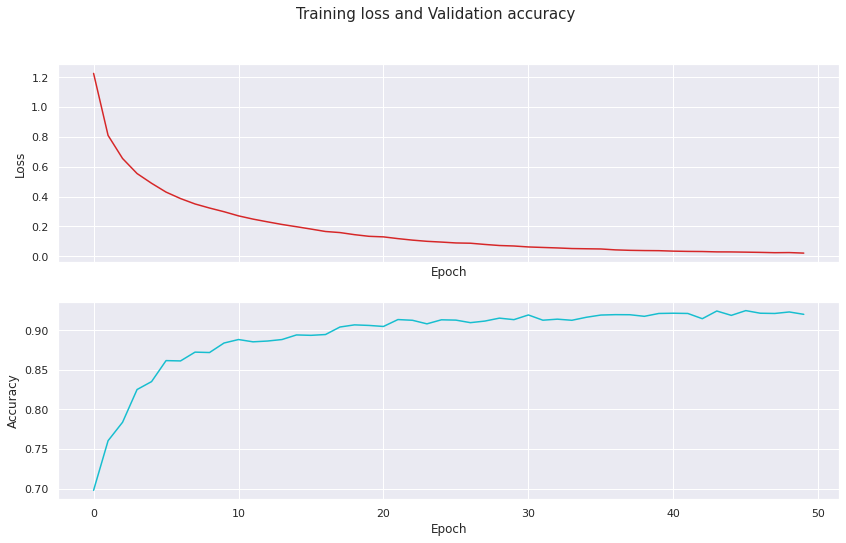

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 8), sharex=True)
fig.suptitle('Training loss and Validation accuracy', size=15)

ax1.plot([*range(EPOCHS)], train_loss_list, 'tab:red', label='train loss')
ax1.set(xlabel='Epoch', ylabel='Loss')

plt.plot([*range(EPOCHS)], accuracy_list, 'tab:cyan', label='accuracy')
ax2.set(xlabel='Epoch', ylabel='Accuracy')

fig.show()

It is interesting to notice how the model reach about **80% of accuracy**, after **only 3 epochs**.

## Evaluation

In [ ]:
_, _, testloader = data_loaders(
    trainset, validationset, testset, config['batch_size']
)

In [ ]:
trained_net = ResNet()
trained_net.to(device)
trained_net.load_state_dict(torch.load('cnn.pt'))

<All keys matched successfully>

In [ ]:
overall_accuracy = test_accuracy(trained_net, testloader)

print(
    f'{color.bold}{color.cyan}Overall accuracy of the network{color.end}  '
    f'{(overall_accuracy * 100):.2f} %\n'
    f'{color.underline}on the 10000 test images'
)

Overall accuracy of the network  91.66 %
on the 10000 test images


In [ ]:
accuracy_per_class = test_accuracy_per_class(trained_net, testloader)

print(f'{color.bold}{color.cyan}Accuracy per class{color.end}\n')
for classname, accuracy in accuracy_per_class.items():
    print(f'{classname:12s} {accuracy:.2f} %')

Accuracy per class

airplane     93.40 %
automobile   96.30 %
bird         89.50 %
cat          83.30 %
deer         92.10 %
dog          85.90 %
frog         93.40 %
horse        92.40 %
ship         94.70 %
truck        95.60 %


The results are really interesting in terms of accuracy, with some classes that exceed the 95% of accuracy. The worst classes are *dog*, *cat* and *bird*. 

# Conclusions

This experimental notebook allowed to test a well-known model as the CNNs are, against an easy and well designed dataset such as the CIFAR10.
The accuracy achieved confirms the state-of-the-art knowledge in the field of image classification, in which the CNNs are one of the most performant and reliable model known.